In [58]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import anndata2ri
import logging

from matplotlib import pyplot as plt
from scipy.sparse import issparse, csr_matrix

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
# import r
from rpy2.robjects import r

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

from datetime import date

DATA_VERSION = date.today()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/scratch/23700893/ipykernel_3602300/1887550356.py:18: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [45]:
sc.settings.set_figure_params(dpi=100)
sc.settings.verbosity = 3
sc.settings.n_jobs = 2
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)
plt.rcParams['figure.figsize']=(7,7)

In [3]:
%%R
library(scran)
library(BiocParallel)
library(scry)

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: 'MatrixGenerics'

The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

#### Read and clean the seurat object into an adata object

In [4]:
org = "/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_seurat.rds"

adata = r(
    f"library(Seurat)\n"
    f"as.SingleCellExperiment(readRDS('{org}'), assay='RNA')\n"
)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [5]:
adata.obs = adata.obs[adata.obs.columns.drop(list(adata.obs.filter(regex='pANN')))]
adata.obs = adata.obs[adata.obs.columns.drop(list(adata.obs.filter(regex='DF')))]
adata.obs = adata.obs.drop(columns=['RNA_snn_res.0.8','seurat_clusters','RNA_res.0.8','ident'])

In [6]:
adata.layers['counts'] = adata.X.copy()

In [8]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:,mt_gene_index].sum(1) / adata.X.sum(1)

In [10]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata

AnnData object with n_obs × n_vars = 55327 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction'
    var: 'mt', 'ribo'
    layers: 'logcounts', 'counts'

In [11]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 55327 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'logcounts', 'counts'

#### Now we have a cleaned object filtered and preprocessed with our previously used pipeline. Here I want to add some more processing, like comparing other normalization techniques and selection of HVG

In [39]:
adata_tmp = adata.copy()

<Axes: title={'center': 'mt fraction'}, xlabel='n_counts', ylabel='n_genes'>

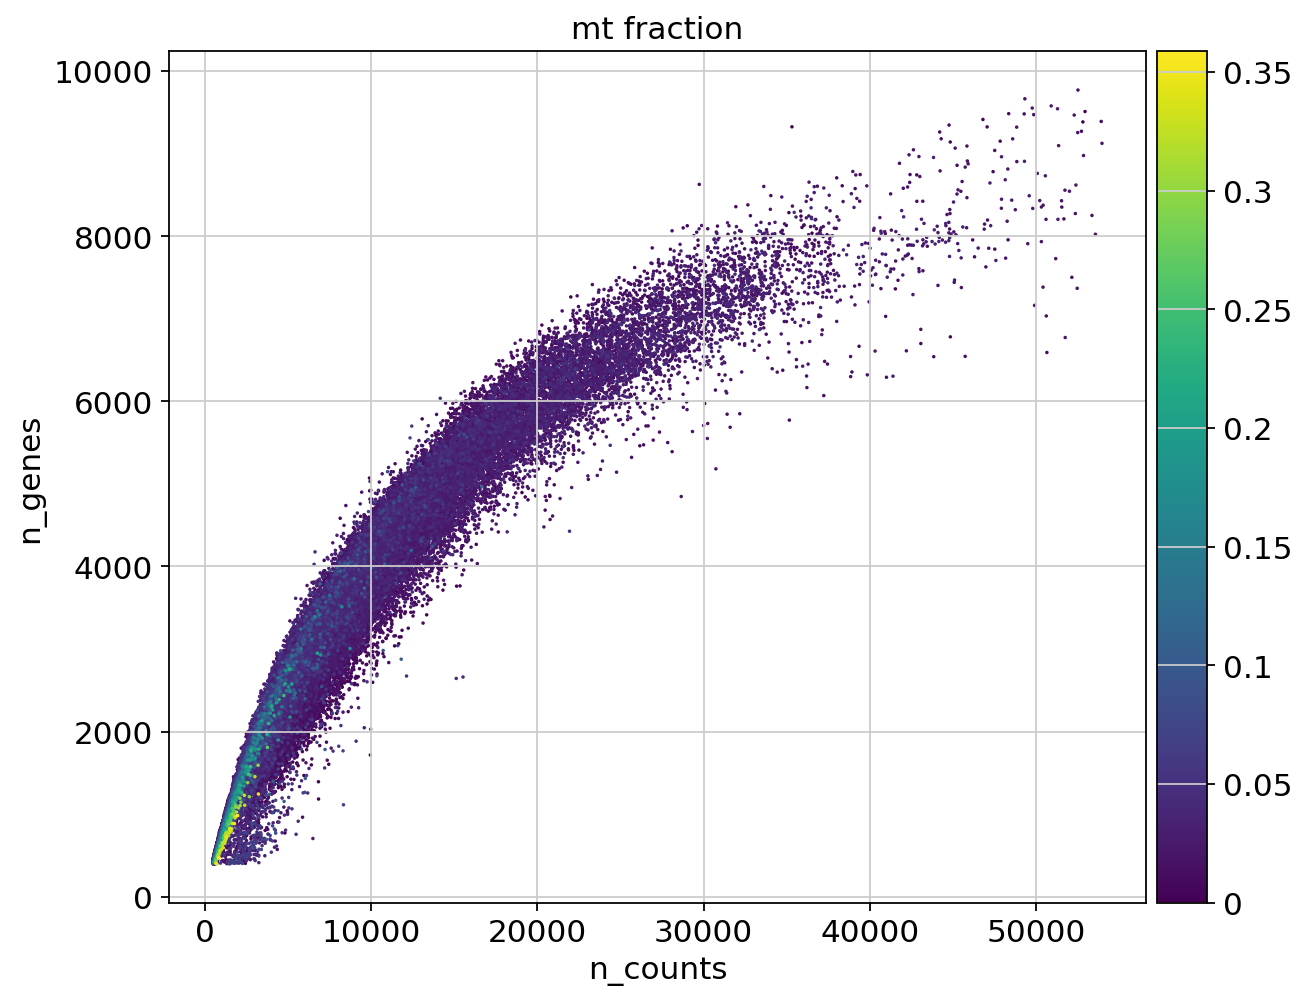

In [40]:
plt.rcParams['figure.figsize']=(7,7)
sc.pl.scatter(adata,
              y='n_genes',x='n_counts', color='mt_fraction', size = 10, show=False)

Quick visual sanity check (umaps) and preparation for scran normalization (leiden clustering)

In [41]:
sc.pp.normalize_total(adata_tmp,target_sum = 1e4)
sc.pp.log1p(adata_tmp)

normalizing counts per cell
    finished (0:00:00)


In [43]:
adata_tmp

AnnData object with n_obs × n_vars = 55327 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'logcounts', 'counts', 'log1p_norm', 'analytic_pearson_residuals'

In [46]:
sc.tl.pca(adata_tmp, svd_solver='arpack')
sc.pp.neighbors(adata_tmp)

computing PCA
    with n_comps=50
    finished (0:01:40)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:27)


In [47]:
sc.tl.leiden(adata_tmp, resolution=0.5)
sc.tl.umap(adata_tmp)

running Leiden clustering
    finished: found 29 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:30)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


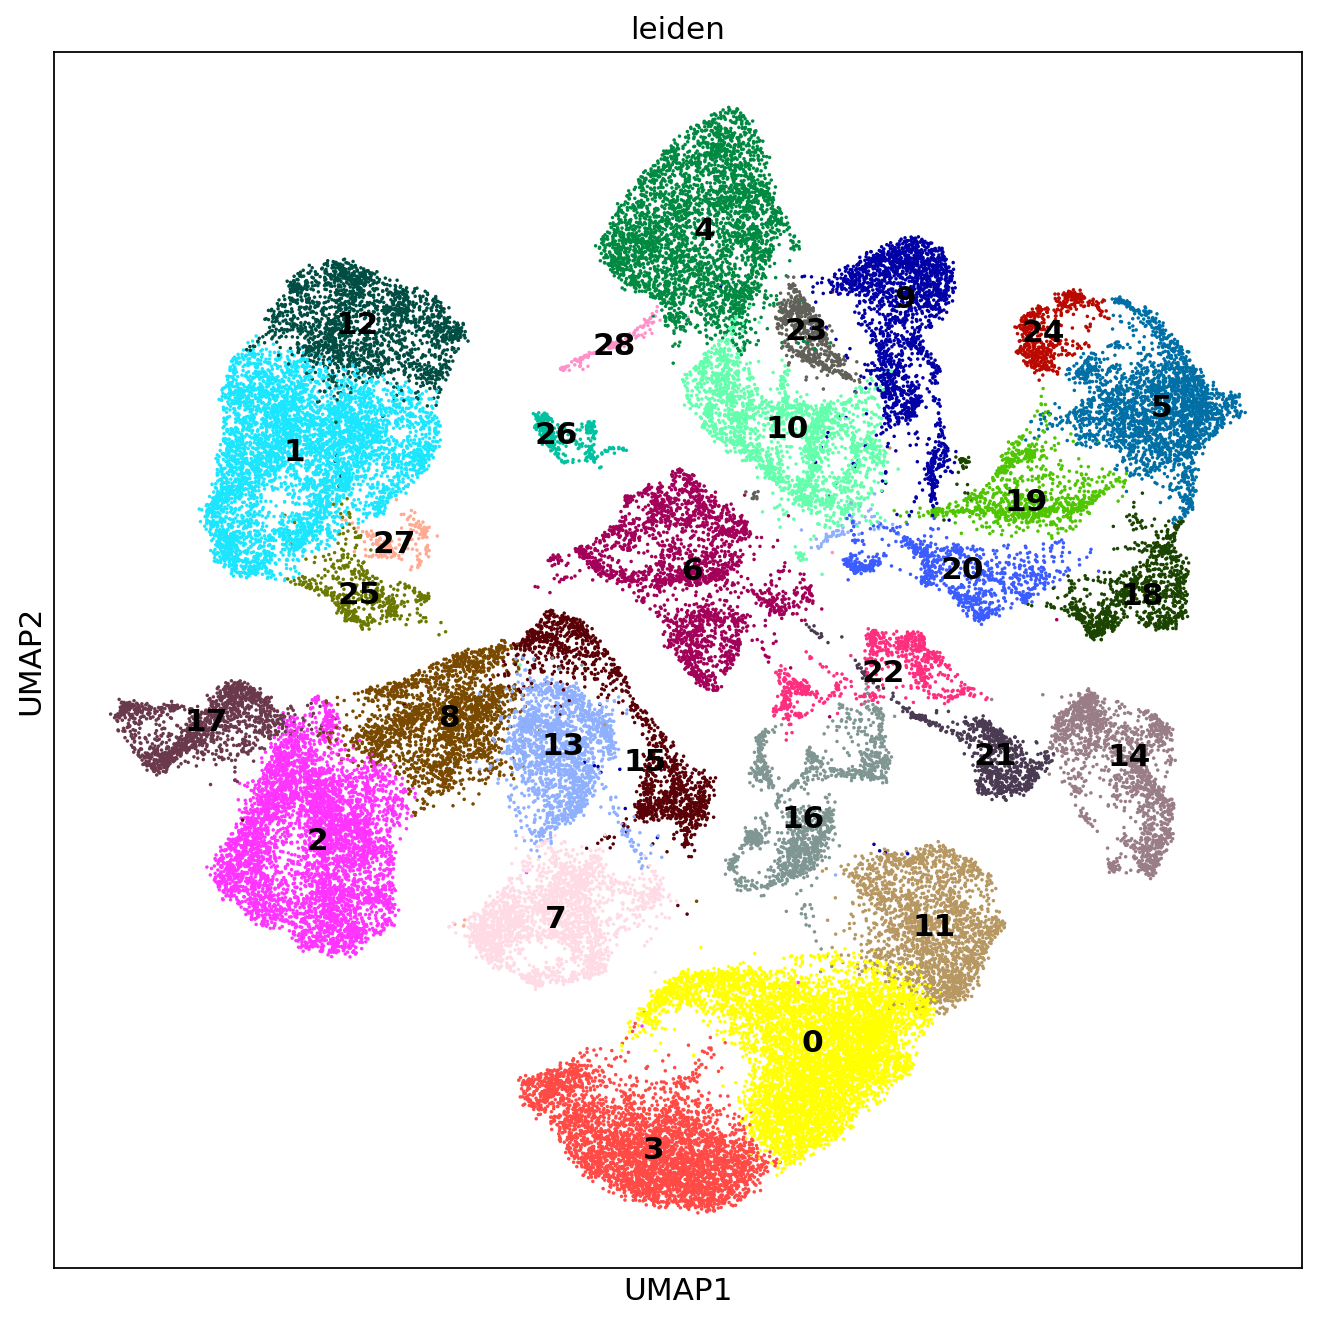

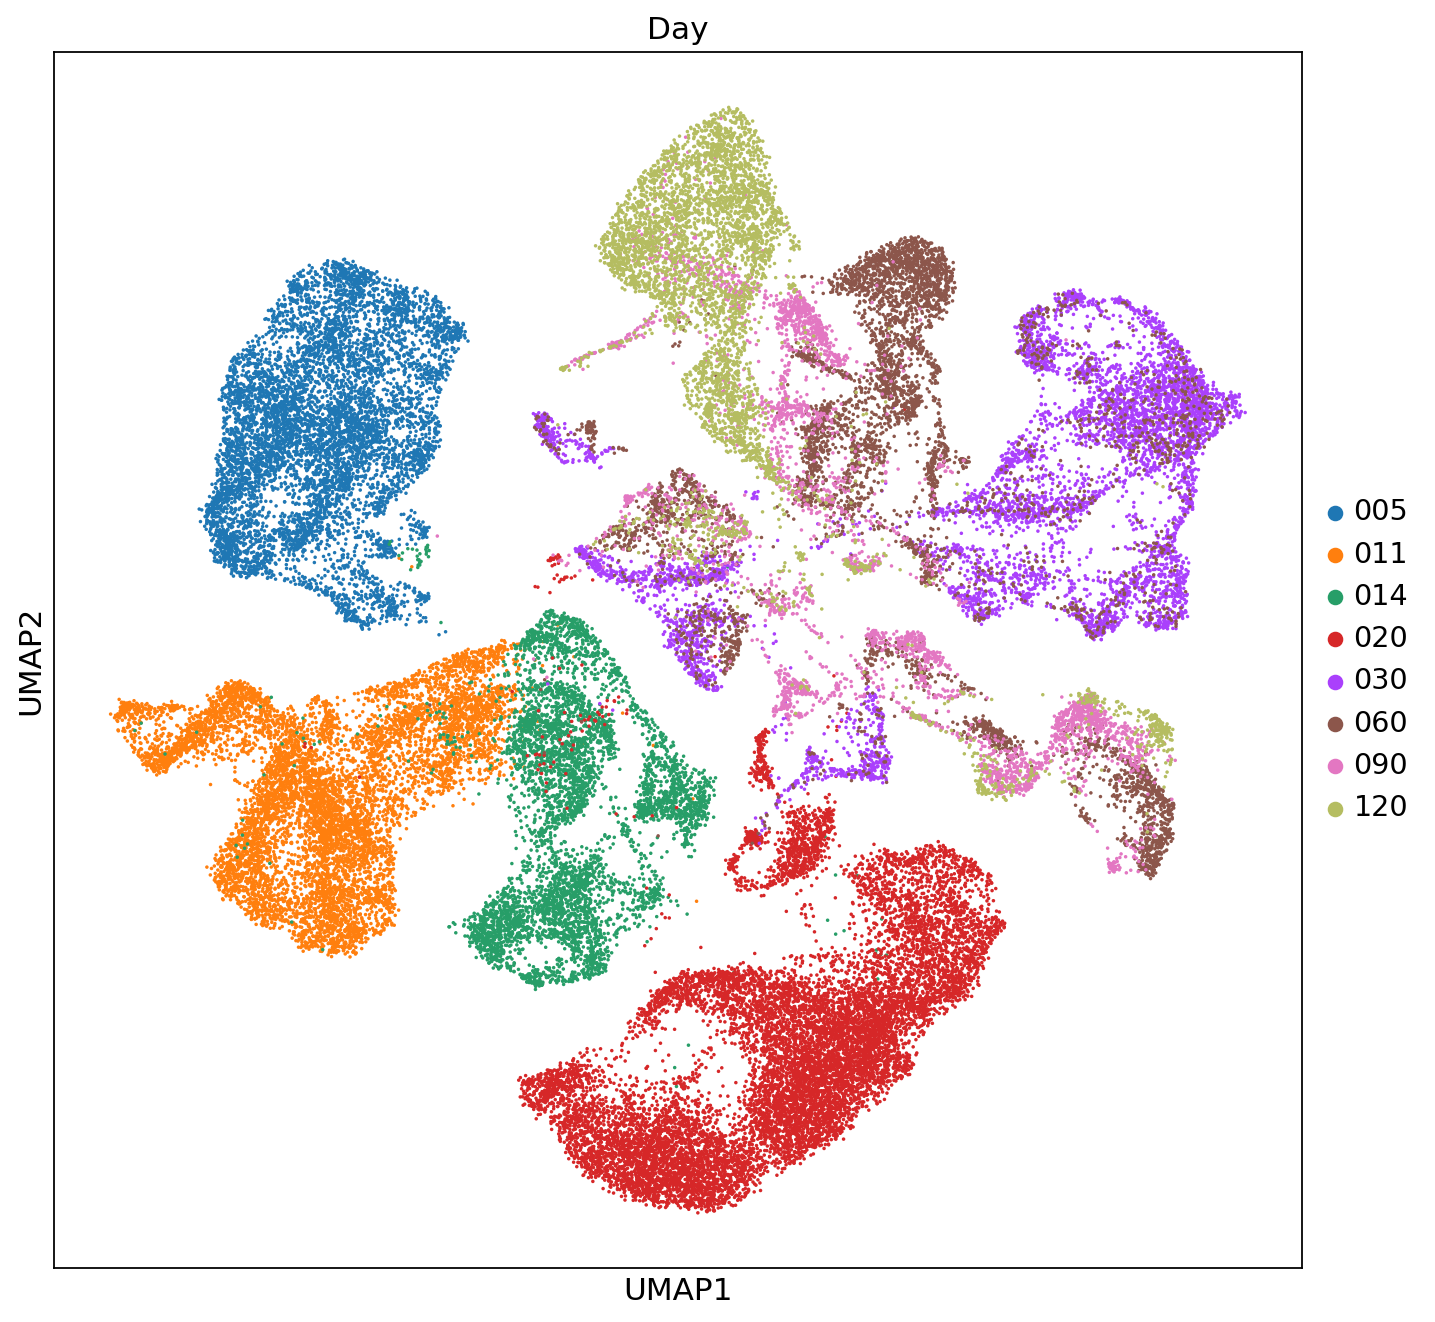

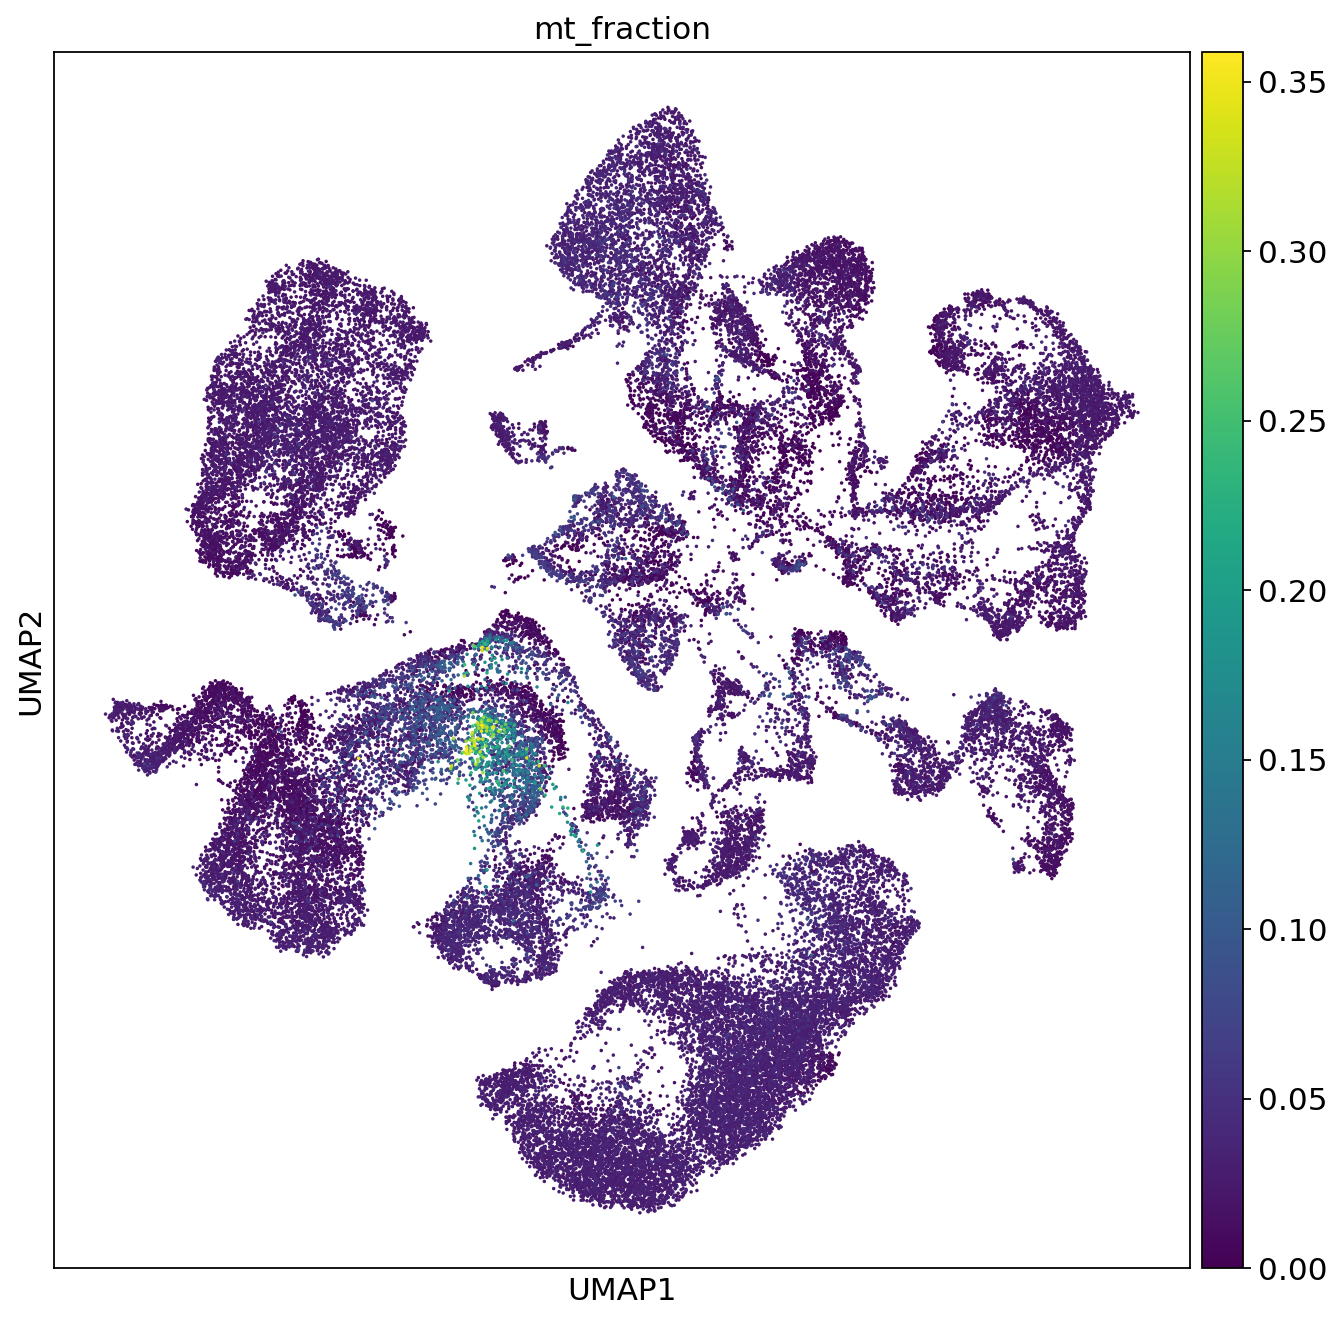

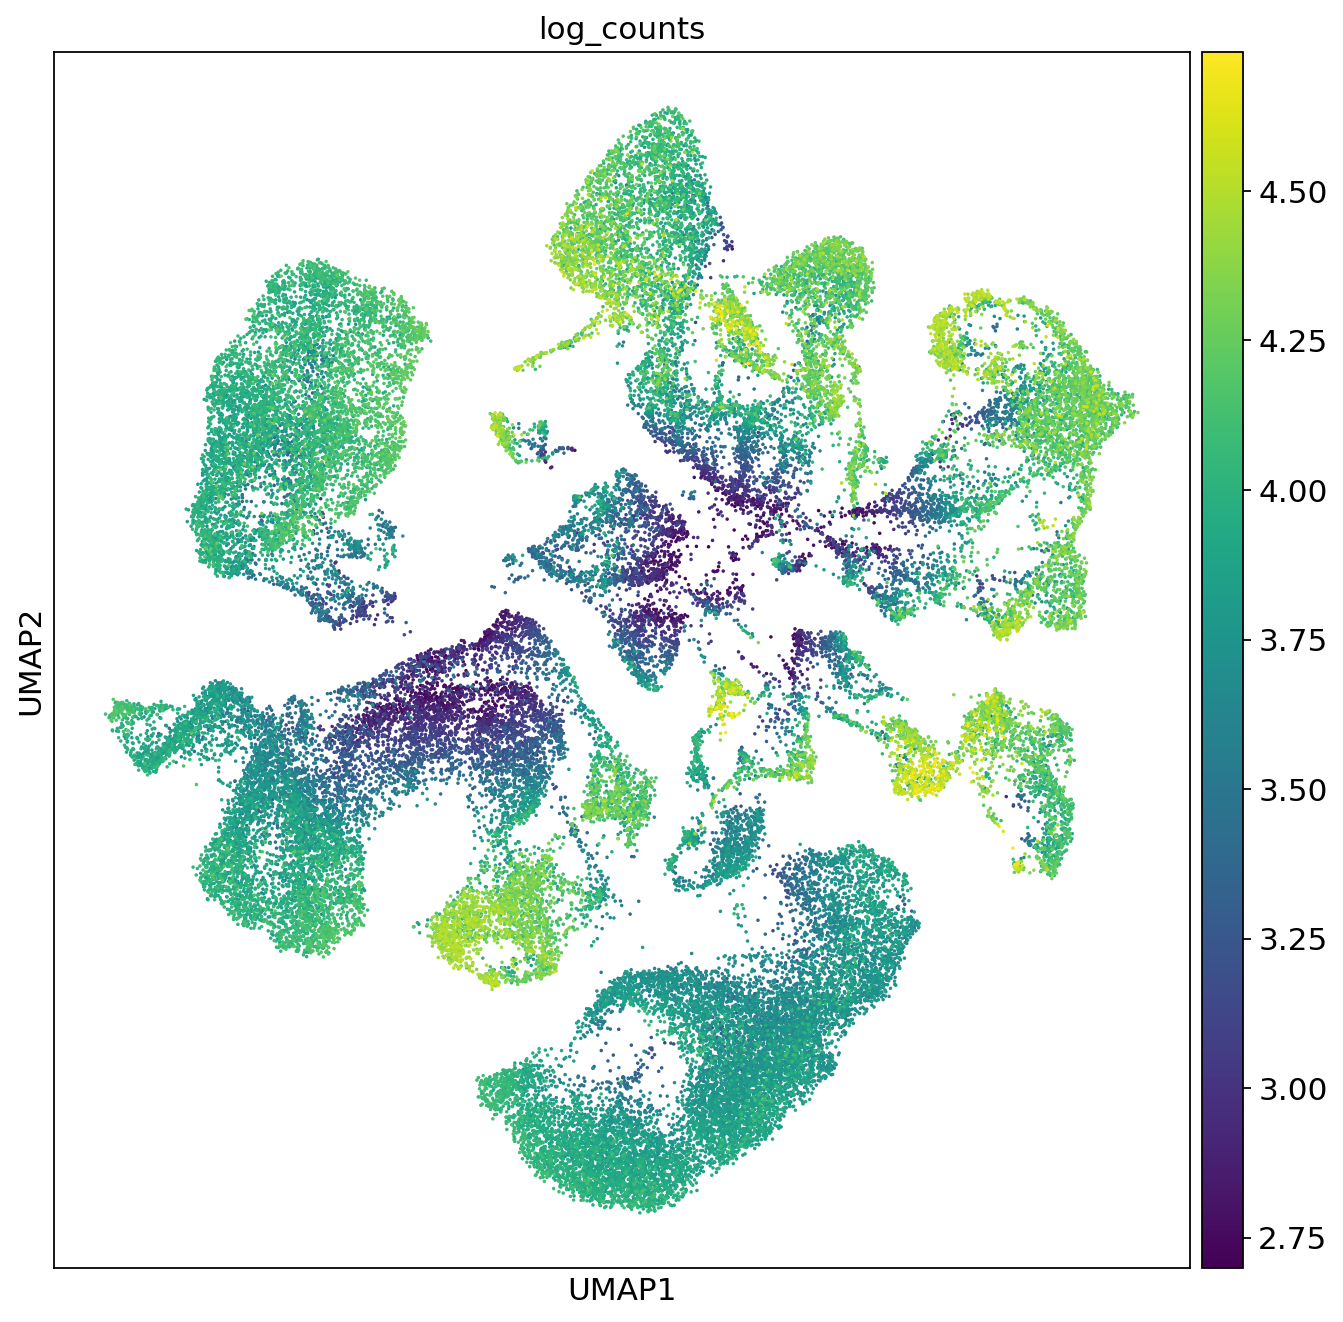

In [66]:
plt.rcParams['figure.figsize']=(10,10)
sc.pl.umap(adata_tmp, color='leiden', size=10, legend_loc='on data')
sc.pl.umap(adata_tmp, color='Day', size=10)
sc.pl.umap(adata_tmp, color='mt_fraction', size=10)
sc.pl.umap(adata_tmp, color='log_counts', size=10)

 # Normalization

 We apply three normalization methods:

1.Shifted logarithm: The shifted logarithm is a fast normalization technique, outperforms other methods for uncovering the latent structure of the dataset (especially when followed by principal component analysis) and works beneficial for stabilizing variance for subsequent dimensionality reduction and identification of differentially expressed genes. Stored as 'log1p_norm'.

2.scran follows the same principles as the shifted logarithm. The only difference now is that Scran leverages a deconvolution approach to estimate the size factors based on a linear regression over genes for pools of cells. This approach aims to better account for differences in count depths across all cells present in the dataset. Stored as 'scran_normalized'

3.Analytic Pearson residuals. Negative residuals for a cell and gene indicate that less counts are observed than expected compared to the gene’s average expression and cellular sequencing depth. Positive residuals indicate the more counts respectively. 

### Seurat LogNormalized

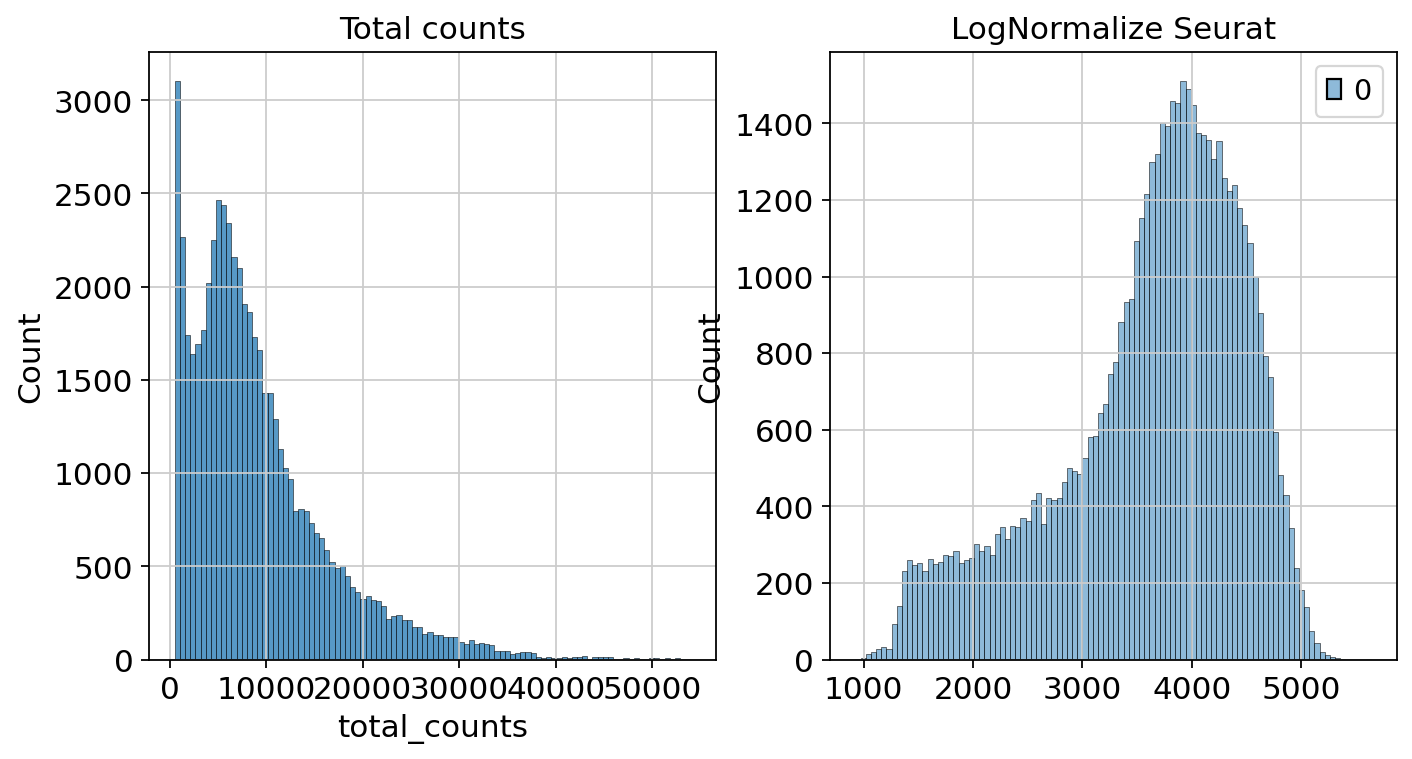

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["logcounts"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("LogNormalize Seurat")
plt.show()

Before running scran, we have to check whether all clusters are large enough to estimate a size factor. 

In [63]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(adata_tmp.obs['leiden'].value_counts())

leiden
0     6232
1     4919
2     4859
3     3934
4     3386
5     2574
6     2423
7     2219
8     2128
9     2120
10    2107
11    2084
12    1956
13    1840
14    1600
15    1430
16    1427
17    1395
18    1011
19     932
20     929
21     800
22     732
23     604
24     557
25     480
26     297
27     185
28     167
Name: count, dtype: int64


No clusters with <100 cells observed so no need to merge clusters

In [64]:
sc.tl.paga(adata_tmp, groups='leiden')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:03)


--> added 'pos', the PAGA positions (adata.uns['paga'])


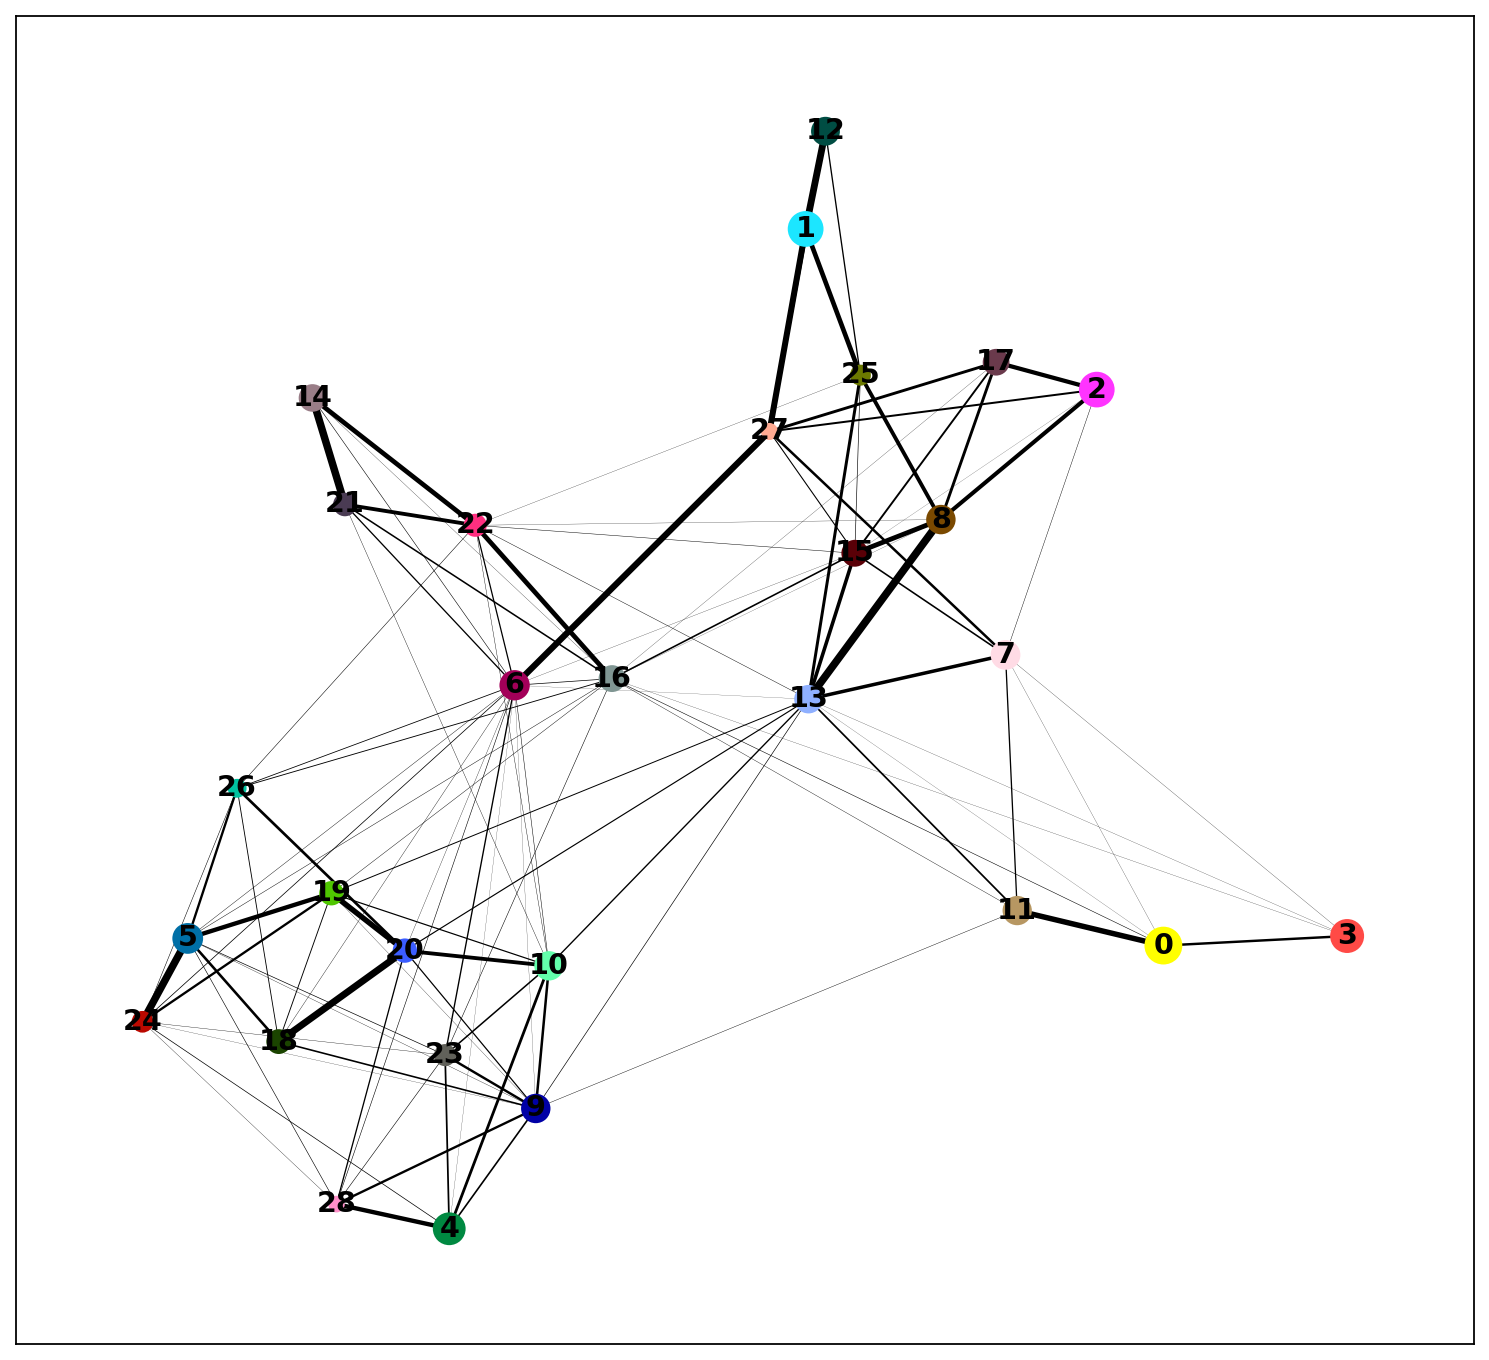

In [67]:
plt.rcParams['figure.figsize']=(10,10)
sc.pl.paga(adata_tmp, edge_width_scale=1)

In [69]:
adata_tmp.obs['groups'] = adata_tmp.obs['leiden']
#adata_tmp.obs['groups'][adata_tmp.obs['leiden']=='29'] = '21'
adata_tmp.obs['groups'] = adata_tmp.obs['groups'].cat.remove_unused_categories()

## scran normalization

In [70]:
#Preprocess variables for scran normalization
input_groups = adata_tmp.obs['groups']
data_mat = adata_tmp.X.T

In [71]:
%%R -i data_mat -i input_groups -o size_factors

# For Bioc version <= 3.10
#size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)
# For Bioc version = 3.11
size_factors = computeSumFactors(SingleCellExperiment::SingleCellExperiment(list(counts=data_mat)), clusters =input_groups, min.mean=0.1)

In [72]:
size_factors = size_factors.obs.sizeFactor.values

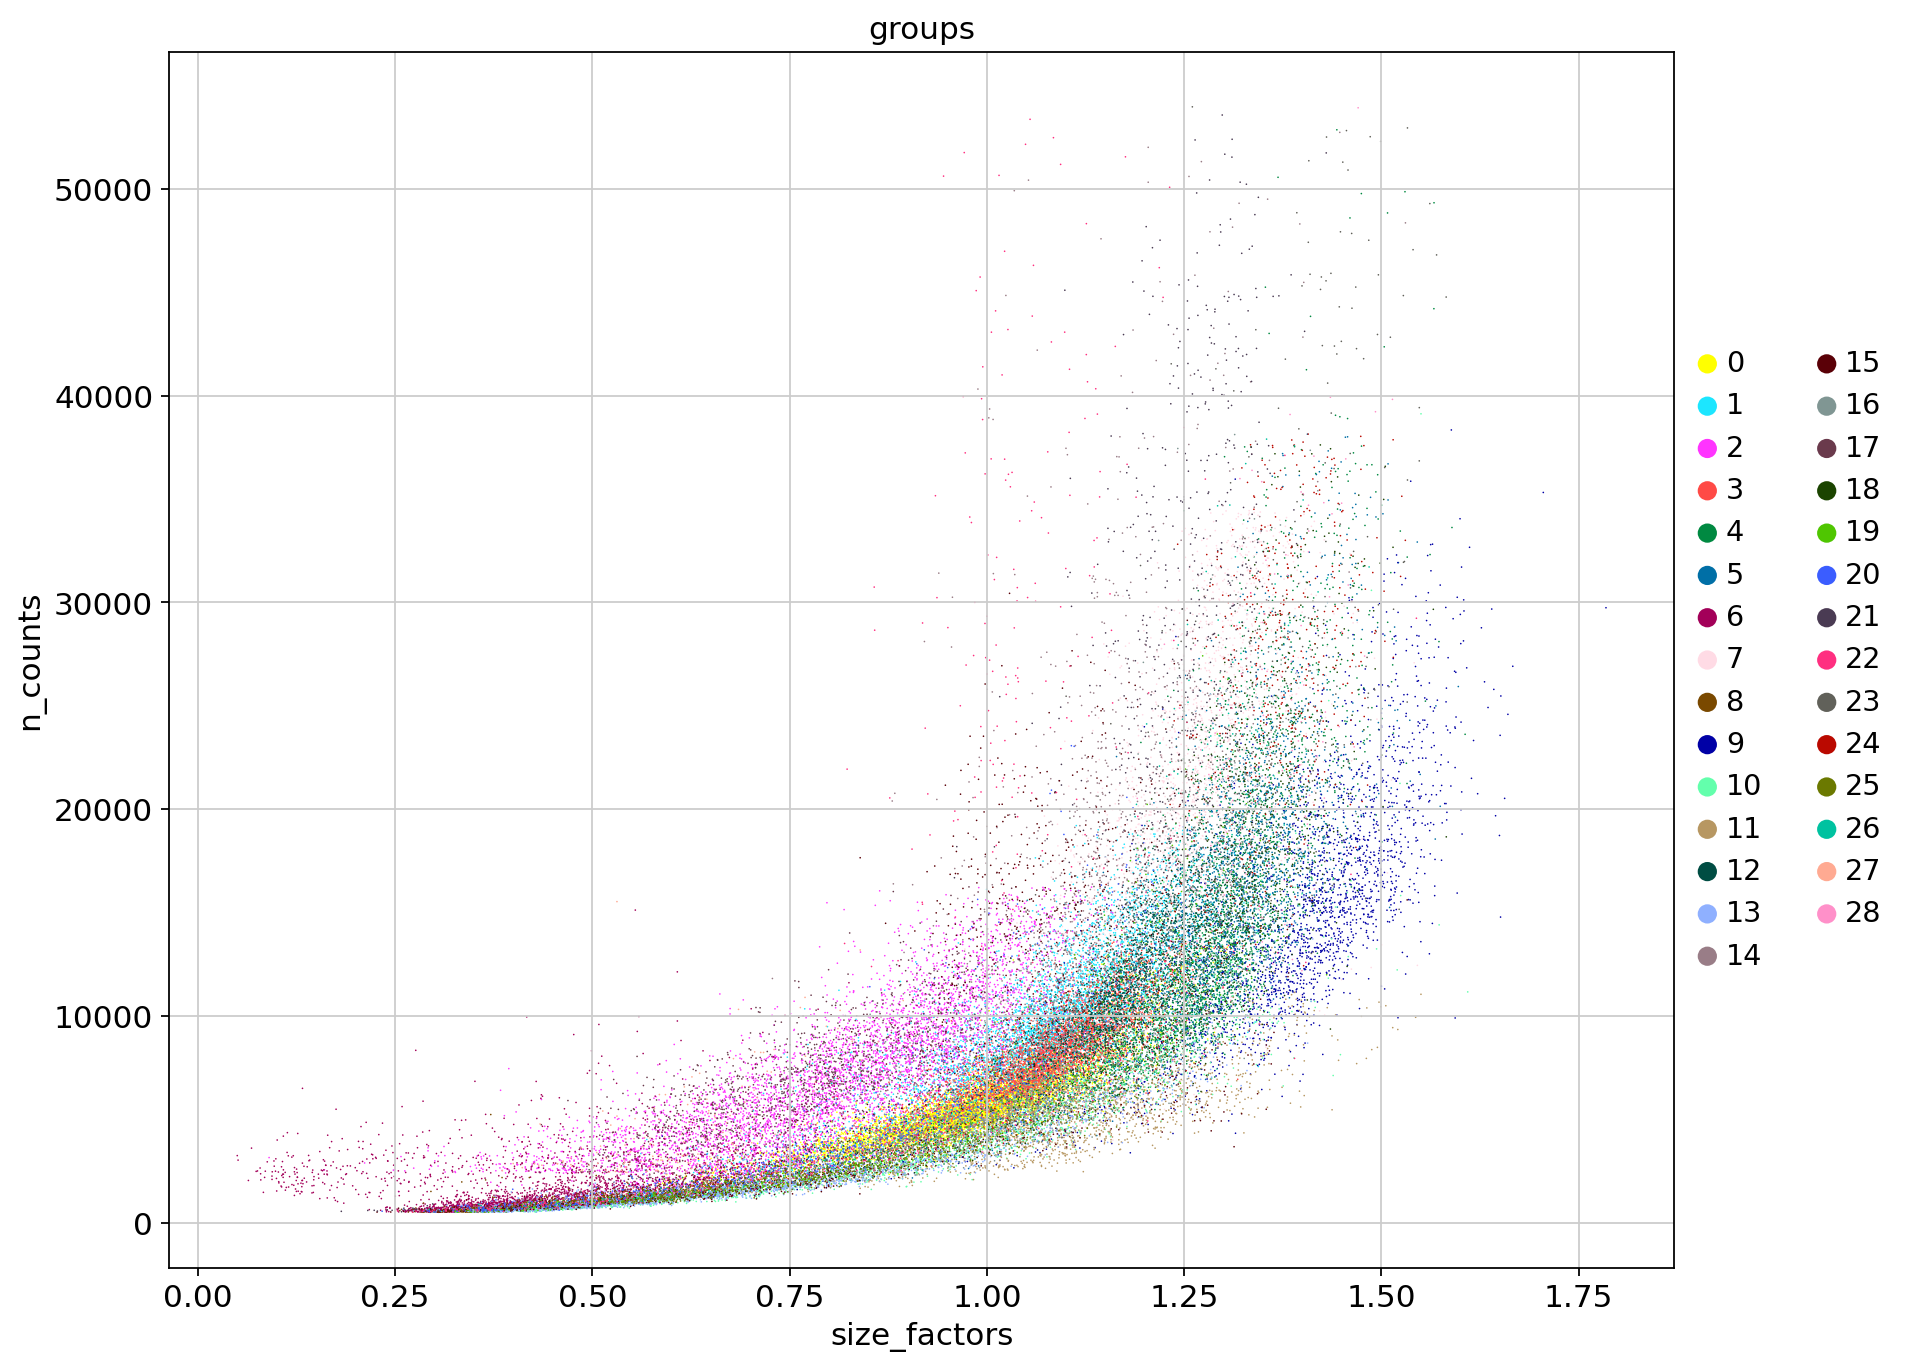

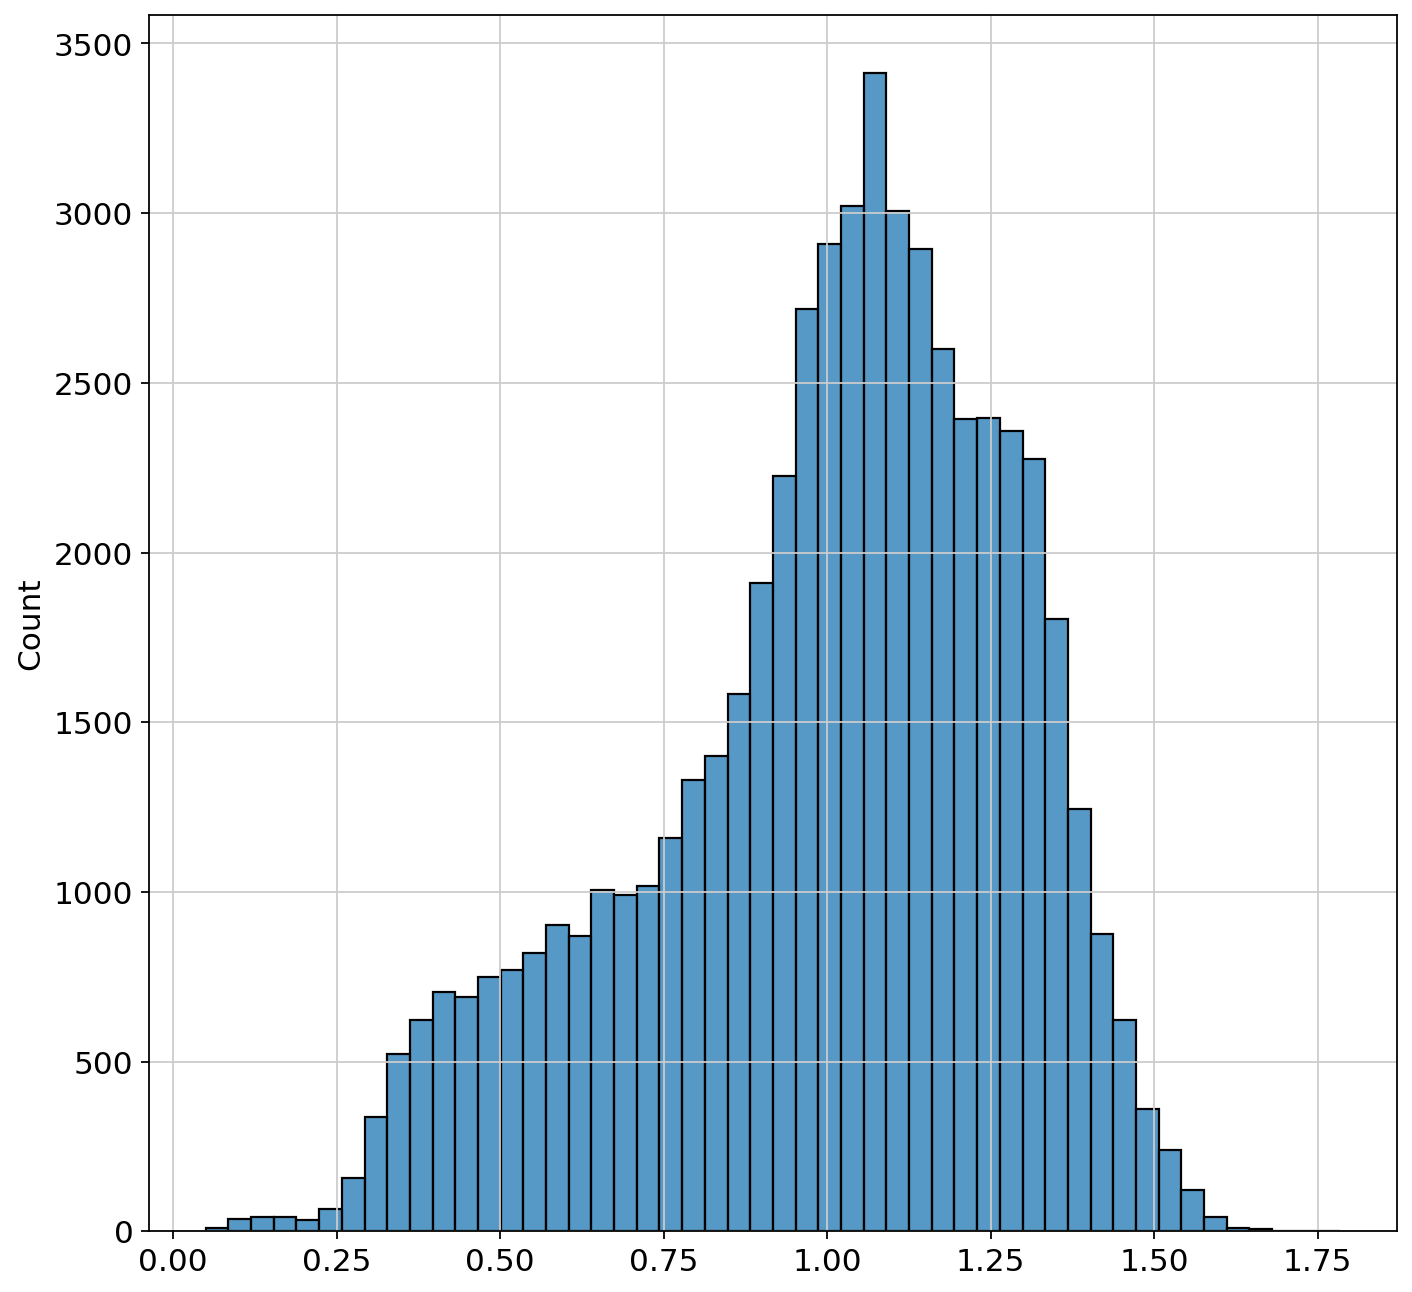

In [74]:
# Visualize the estimated size factors
adata_tmp.obs['size_factors'] = size_factors

sc.pl.scatter(adata_tmp, 'size_factors', 'n_counts', color='groups')

sns.histplot(size_factors, bins=50, kde=False)
plt.show()

In [84]:
scran = adata_tmp.X / adata_tmp.obs["size_factors"].values[:, None]
adata_tmp.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

In [85]:
adata.layers["scran_normalization"] = adata_tmp.layers["scran_normalization"].copy()

In [86]:
adata

AnnData object with n_obs × n_vars = 55327 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'size_factors'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'logcounts', 'counts', 'log1p_norm', 'analytic_pearson_residuals', 'scran_normalization'

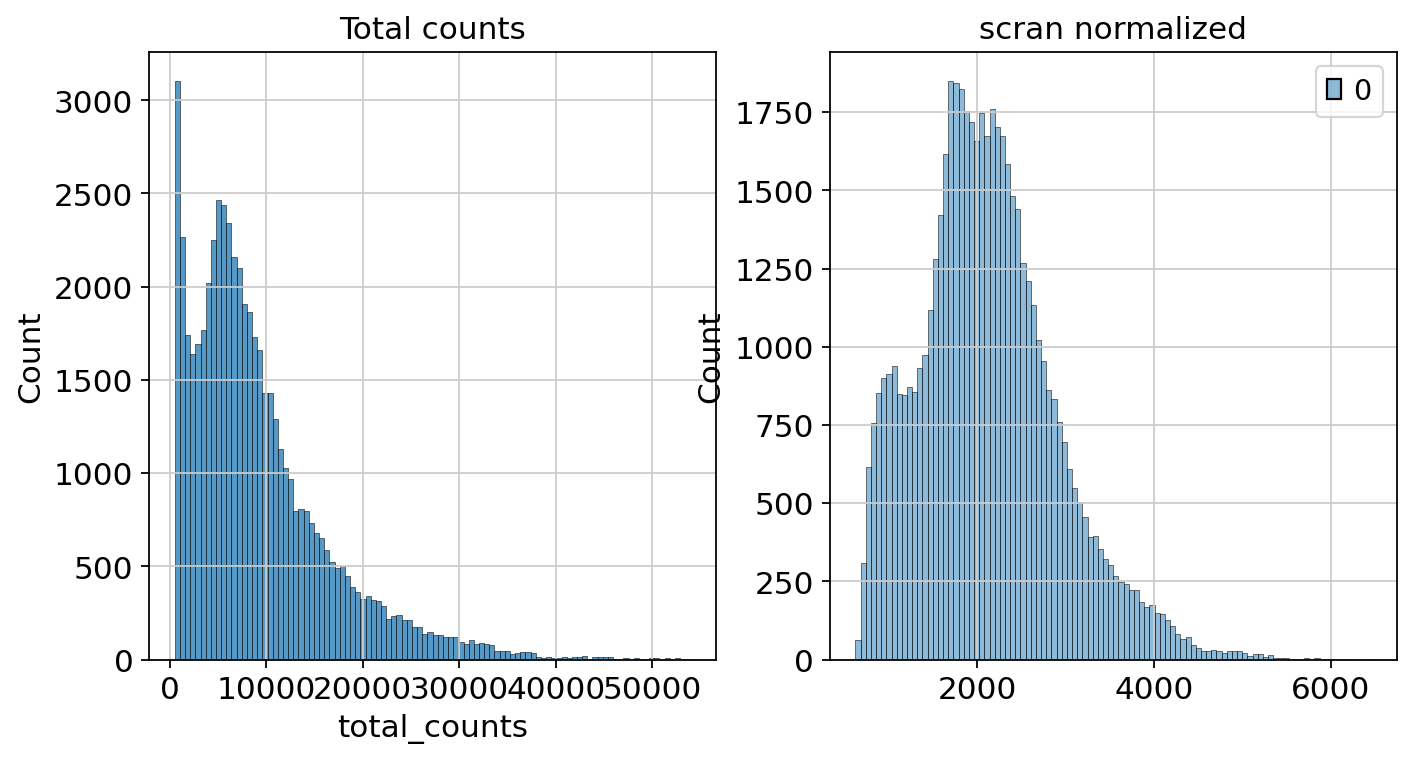

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("scran normalized")
plt.show()

### Shifted logarithm

In [94]:
adata.X = adata.layers['counts'].copy()
adata.X[1:100,1:100].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [95]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:01)


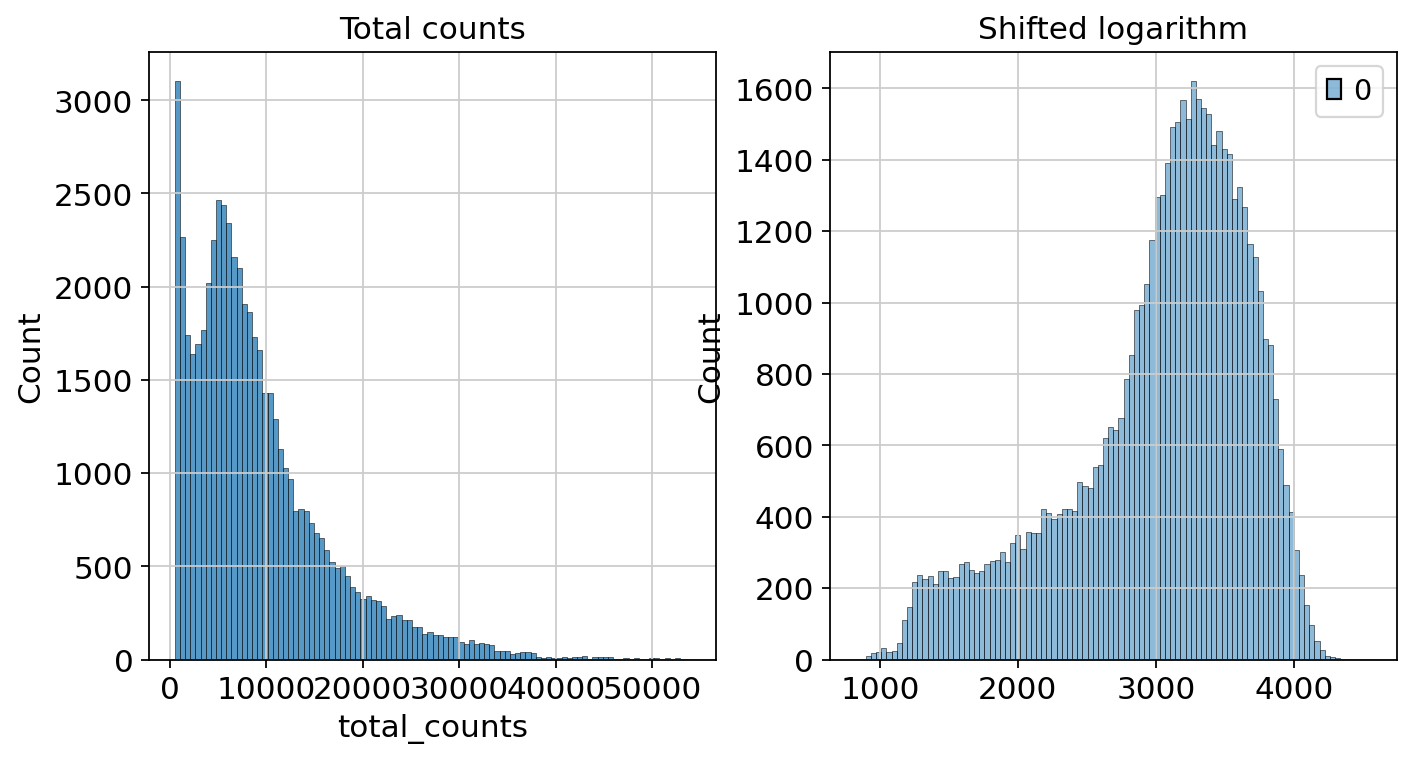

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [104]:
adata


AnnData object with n_obs × n_vars = 55327 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'size_factors'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'logcounts', 'counts', 'log1p_norm', 'scran_normalization'

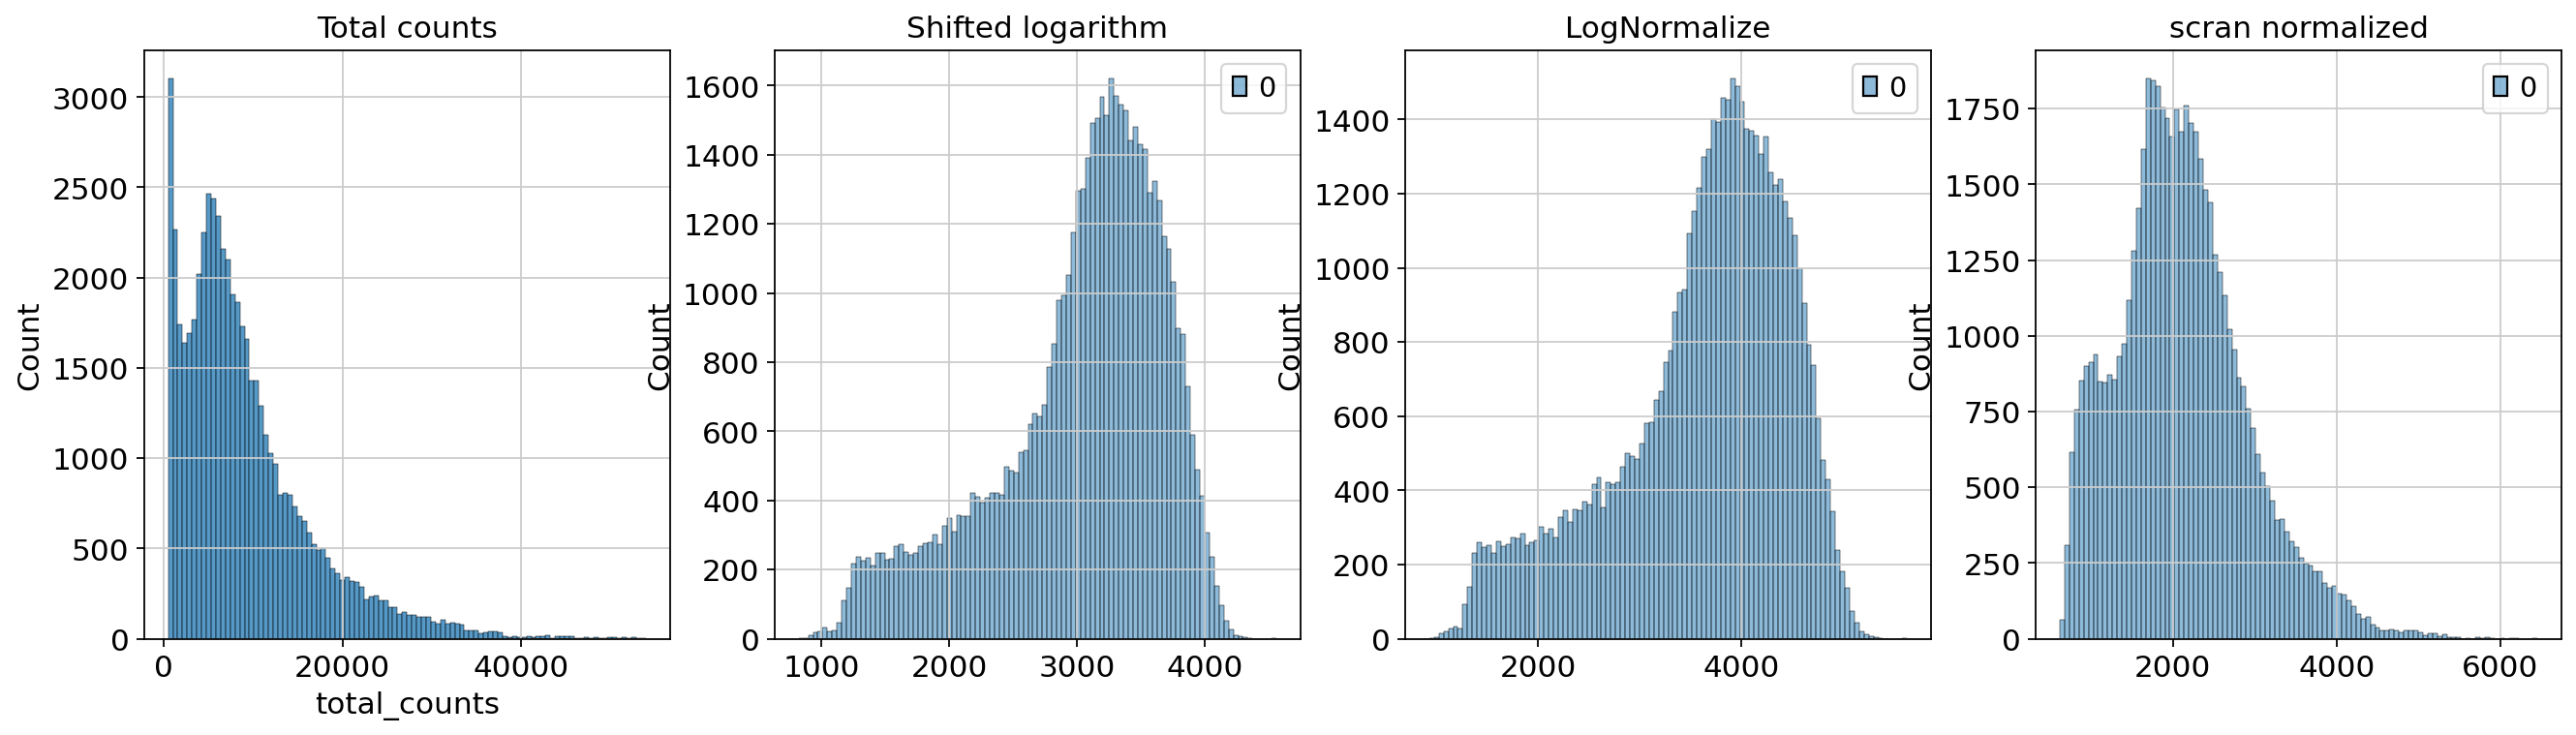

In [107]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
p3 = sns.histplot(adata.layers["logcounts"].sum(1), bins=100, kde=False, ax=axes[2])
axes[2].set_title("LogNormalize")
p4 = sns.histplot(adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[3])
axes[3].set_title("scran normalized")
plt.show()

In [132]:
adata.write('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_normalized.h5ad')